In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import time
import numpy as np 

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


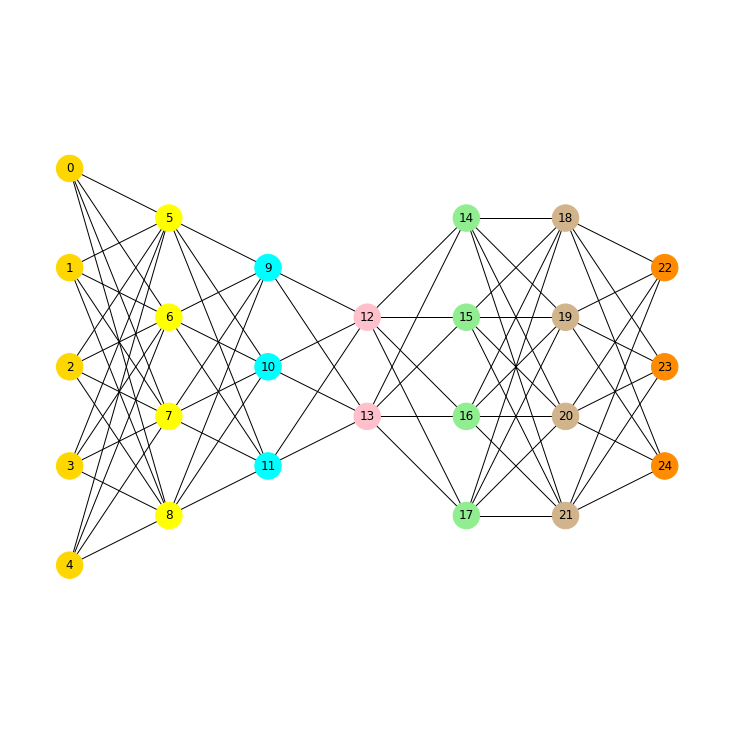

In [2]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "yellow",
    "cyan",
    "pink",
    "lightgreen",
    "tan",
    "darkorange",
]

def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G

G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=700, node_color=color, with_labels=True)
plt.axis("equal")
plt.tight_layout()
plt.show()
ED= [e for e in G.edges() ]
ED.extend([(b,a) for (a,b) in ED ])

In [3]:
N= len(G.nodes())
from pyomo.environ import *

model = AbstractModel()

# Define sets
model.I = RangeSet(N)
model.J = Set(initialize=model.I) # set of destinations

# Define variables
model.x = Var(model.I, model.J, within=Binary) # 
model.flow = Var(model.I, model.J, bounds=(0,1), within=NonNegativeReals) # 

model.st = Var(model.I, within=Binary) # 
model.fn = Var(model.I, within=Binary) # 
model.select = Var(model.I, within=Binary) # 

model.U = Var(model.I, bounds=(0,N-1), within=NonNegativeReals) # 
model.source = Var(model.I, bounds=(0,1), within=NonNegativeReals) # 

def rule_D(model,i,j):
    if (i-1,j-1) in ED:
        return np.sqrt( (pos[i-1][0]-pos[j-1][0])**2 + (pos[i-1][1]-pos[j-1][1])**2 ) 
    else:
        return 0
model.D = Param(model.I, model.J, initialize=rule_D) # 

# Define constraints
def rule_st(model):
    return sum(model.st[i] for i in model.I ) == 1
model.C1 = Constraint(rule=rule_st)

def rule_fn(model):
    return sum(model.fn[i] for i in model.I ) == 1
model.C2 = Constraint(rule=rule_fn)

def rule_C3(model,i):
    return model.fn[i] + model.st[i] <= 1
model.C3 = Constraint(model.I, rule=rule_C3)

def rule_C4(model,i):
    return model.U[i] <= N*model.select[i]
model.C4 = Constraint(model.I, rule=rule_C4)


def rule_C6A(model,i):
    return sum(model.x[i,j] for j in model.J if (i-1,j-1) in ED) == model.select[i] + model.st[i]
model.C6A = Constraint(model.I, rule=rule_C6A)

def rule_C6B(model,i):
    return sum(model.x[j,i] for j in model.J if (i-1,j-1) in ED) == model.select[i] + model.fn[i]
model.C6B = Constraint(model.I, rule=rule_C6B)


def rule_C7A(model,i):
    return model.fn[i] + model.select[i] <= 1
model.C7A = Constraint(model.I, rule=rule_C7A)

def rule_C7B(model,i):
    return model.st[i] + model.select[i] <= 1
model.C7B = Constraint(model.I, rule=rule_C7B)


def rule_C8(model,i,j):
    if (i-1,j-1) in ED and i>j:
        return model.x[i,j]+model.x[j,i] <= 1
    else:
        return Constraint.Skip
model.C8 = Constraint(model.I,model.J, rule=rule_C8)

def rule_C9(model,i,j):
    if (i-1,j-1) in ED:
        return model.flow[i,j]<= model.x[i,j]
    else:
        return Constraint.Skip
model.C9 = Constraint(model.I,model.J, rule=rule_C9)

def rule_C10(model,i):
    return model.source[i]-(model.select[i]+model.fn[i])/N ==  sum(model.flow[i,j]-model.flow[j,i] for j in model.J if (i-1,j-1) in ED)
model.C10 = Constraint(model.I, rule=rule_C10)

def rule_C11(model,i):
    return model.source[i] <= model.st[i] 
model.C11 = Constraint(model.I, rule=rule_C11)


# Define objective function
def rule_OF(model):
    return sum(model.D[i+1,j+1]*model.x[i+1,j+1] for (i,j) in ED)
model.OF = Objective(rule=rule_OF,sense=maximize)

# Solve the optimization problem
opt = SolverFactory('cbc')
instance = model.create_instance()

In [4]:
instance.st[5].fix(1)
instance.fn[23].fix(1)

results = opt.solve(instance) # solves and updates instance

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)
print(value(instance.OF) )

feasible
14.126210284683118


Start =  4
Final =  22
4  ----->   5
5  ----->   3
3  ----->   6
6  ----->   1
1  ----->   7
7  ----->   0
0  ----->   8
8  ----->   9
9  ----->   13
13  ----->   11
11  ----->   12
12  ----->   17
17  ----->   18
18  ----->   24
24  ----->   19
19  ----->   16
16  ----->   20
20  ----->   14
14  ----->   21
21  ----->   22


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


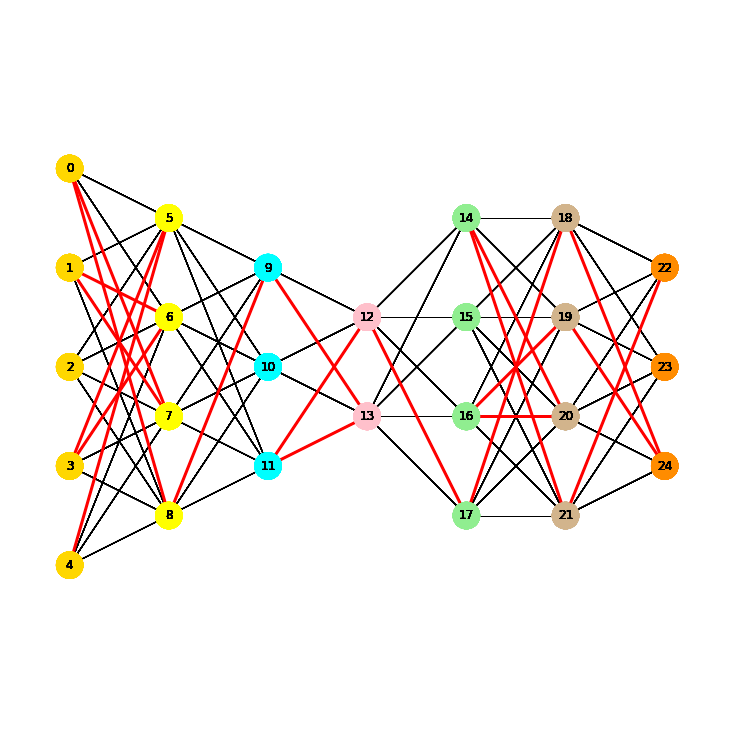

In [5]:
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=color, with_labels=True)
for i in instance.I:
    if value(instance.st[i])>0:
        print('Start = ', i-1)
        start_node = i-1
    if value(instance.fn[i])>0:
        print('Final = ', i-1)
        final_node = i-1
counter = 0         
while start_node!= final_node:
    for (i,j) in ED:
        if value(instance.x[i+1,j+1])>0 and i == start_node:
            print(i,' ----->  ', j)
            x1,y1 = pos[i][0],pos[i][1]
            x2,y2 = pos[j][0],pos[j][1]
            plt.plot([x1,x2],[y1,y2],lw=3, c='r')
            nx.draw(G, pos, node_size=700, node_color=color, with_labels=True)
            start_node = j
            plt.axis("equal")
            plt.tight_layout()            
plt.show()